# Day 5: Multi-Class Classification for Trading

## 🎯 Learning Objectives
- Extend binary to multi-class classification
- Create BUY/HOLD/SELL labels
- Handle class imbalance
- Compare multi-class strategies

---

## 📚 Theory: Multi-Class Classification

### Why Multi-Class?
Binary (UP/DOWN) ignores middle ground:
- Small returns → noise
- Transaction costs matter
- Better to have HOLD class

### Label Construction
$$y = \begin{cases} 2 \text{ (BUY)} & r > \tau_{high} \\ 1 \text{ (HOLD)} & -\tau_{low} \leq r \leq \tau_{high} \\ 0 \text{ (SELL)} & r < -\tau_{low} \end{cases}$$

### Multi-Class Strategies

| Strategy | Description |
|----------|-------------|
| One-vs-Rest (OvR) | Train K binary classifiers |
| One-vs-One (OvO) | Train K(K-1)/2 pairwise classifiers |
| Multinomial | Single model, softmax output |

### Evaluation Metrics
- **Macro F1**: Average F1 across classes
- **Weighted F1**: F1 weighted by class frequency
- **Cohen's Kappa**: Agreement accounting for chance

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             cohen_kappa_score, f1_score)
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days for {ticker}")

📥 Downloading data...
✅ Data: 1256 days for AAPL


In [2]:
# Create features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Technical features
for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

df['volatility_10'] = returns.rolling(10).std()
df['volatility_20'] = returns.rolling(20).std()

# Moving averages
df['ma_ratio_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1
df['ma_ratio_20_50'] = prices.rolling(20).mean() / prices.rolling(50).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# Future return
df['next_return'] = returns.shift(-1)

df = df.dropna()
print(f"📊 Dataset: {len(df)} samples")

📊 Dataset: 1206 samples


In [3]:
# Create multi-class labels
def create_multiclass_labels(returns, threshold_pct=50):
    """
    Create 3-class labels: SELL (0), HOLD (1), BUY (2)
    
    Parameters:
    - returns: Return series
    - threshold_pct: Percentile for BUY/SELL threshold
    """
    # Use percentile-based thresholds for balanced classes
    low_threshold = np.percentile(returns.dropna(), 100 - threshold_pct)
    high_threshold = np.percentile(returns.dropna(), threshold_pct)
    
    labels = np.where(returns > high_threshold, 2,  # BUY
                     np.where(returns < low_threshold, 0,  # SELL
                             1))  # HOLD
    return labels, low_threshold, high_threshold

# Create labels with top/bottom 33% as signals
labels, low_thresh, high_thresh = create_multiclass_labels(df['next_return'], threshold_pct=67)
df['target'] = labels

print(f"\n📊 Label Thresholds:")
print(f"   SELL: return < {low_thresh:.4f} ({low_thresh*100:.2f}%)")
print(f"   BUY: return > {high_thresh:.4f} ({high_thresh*100:.2f}%)")

print(f"\n🎯 Class Distribution:")
class_names = {0: 'SELL', 1: 'HOLD', 2: 'BUY'}
for val, name in class_names.items():
    count = (df['target'] == val).sum()
    print(f"   {name}: {count} ({count/len(df):.1%})")


📊 Label Thresholds:
   SELL: return < -0.0048 (-0.48%)
   BUY: return > 0.0062 (0.62%)

🎯 Class Distribution:
   SELL: 398 (33.0%)
   HOLD: 410 (34.0%)
   BUY: 398 (33.0%)


In [4]:
# Prepare data
feature_cols = ['momentum_1', 'momentum_5', 'momentum_10', 'momentum_20',
                'volatility_10', 'volatility_20', 'ma_ratio_5_20', 
                'ma_ratio_20_50', 'rsi']

X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 964, Test: 242


In [5]:
# Train multi-class classifiers
# Note: multi_class parameter removed in sklearn 1.7+, LogisticRegression auto-detects
models = {
    'Logistic (OvR)': LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    'Logistic (Newton)': LogisticRegression(solver='newton-cg', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

print("\n" + "="*70)
print("MULTI-CLASS MODEL COMPARISON")
print("="*70)

results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)
    
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 (Macro)': f1_score(y_test, y_pred, average='macro'),
        'F1 (Weighted)': f1_score(y_test, y_pred, average='weighted'),
        'Kappa': cohen_kappa_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


MULTI-CLASS MODEL COMPARISON


            Model  Accuracy  F1 (Macro)  F1 (Weighted)    Kappa
   Logistic (OvR)  0.351240    0.346537       0.361678 0.038297
Logistic (Newton)  0.355372    0.350854       0.365088 0.044688
    Random Forest  0.404959    0.394198       0.408028 0.096078
Gradient Boosting  0.388430    0.386768       0.389324 0.078498


In [6]:
# Detailed classification report for best model
best_model = 'Random Forest'
print(f"\n{'='*60}")
print(f"DETAILED RESULTS: {best_model}")
print("="*60)
print(classification_report(y_test, predictions[best_model], 
                           target_names=['SELL', 'HOLD', 'BUY']))


DETAILED RESULTS: Random Forest
              precision    recall  f1-score   support

        SELL       0.39      0.44      0.41        73
        HOLD       0.51      0.43      0.46       107
         BUY       0.29      0.32      0.31        62

    accuracy                           0.40       242
   macro avg       0.40      0.40      0.39       242
weighted avg       0.42      0.40      0.41       242



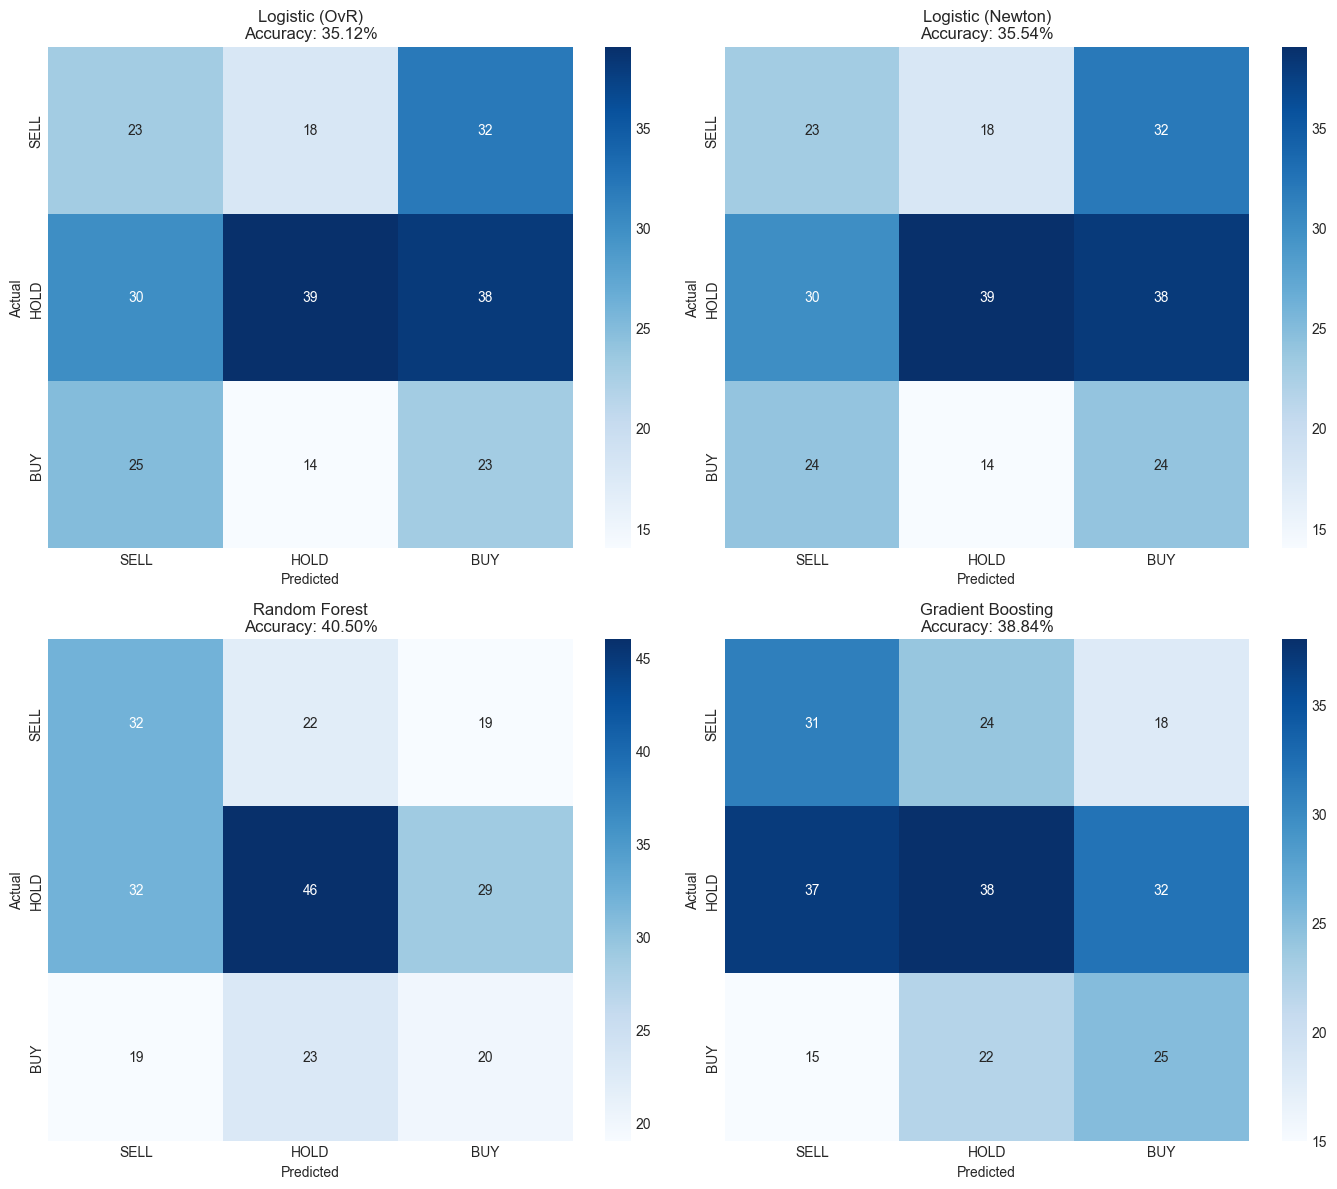

In [7]:
# Confusion matrix visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['SELL', 'HOLD', 'BUY'],
                yticklabels=['SELL', 'HOLD', 'BUY'])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, pred):.2%}')

plt.tight_layout()
plt.show()

In [8]:
# Trading Strategy: Multi-class to positions
# SELL = -1, HOLD = 0, BUY = +1

backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

for name, pred in predictions.items():
    # Convert class labels to positions
    positions = pred - 1  # SELL(0)->-1, HOLD(1)->0, BUY(2)->+1
    backtest[f'{name}_position'] = positions
    backtest[f'{name}_return'] = positions * backtest['actual_return']
    backtest[f'{name}_cum'] = (1 + backtest[f'{name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

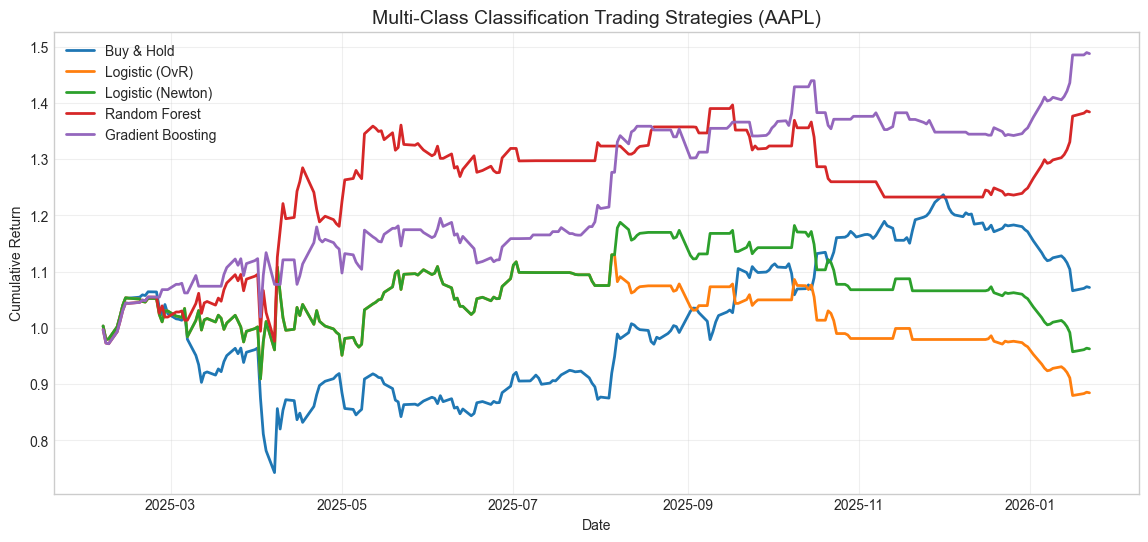

In [9]:
# Plot strategies
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
for name in predictions.keys():
    plt.plot(backtest.index, backtest[f'{name}_cum'], label=name, linewidth=2)
plt.title(f'Multi-Class Classification Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Performance metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*70)
print("STRATEGY PERFORMANCE")
print("="*70)

print(f"\n{'Strategy':<25} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 60)

# Buy and hold
total, sharpe, mdd = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
print(f"{'Buy & Hold':<25} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")

for name in predictions.keys():
    total, sharpe, mdd = calc_metrics(backtest[f'{name}_return'], backtest[f'{name}_cum'])
    print(f"{name:<25} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                     Total Ret     Sharpe     Max DD
------------------------------------------------------------
Buy & Hold                       7.18%       0.23    -30.22%
Logistic (OvR)                 -11.56%      -0.43    -22.16%
Logistic (Newton)               -3.74%      -0.14    -19.38%
Random Forest                   38.40%       1.14    -11.73%
Gradient Boosting               48.77%       1.63     -9.25%


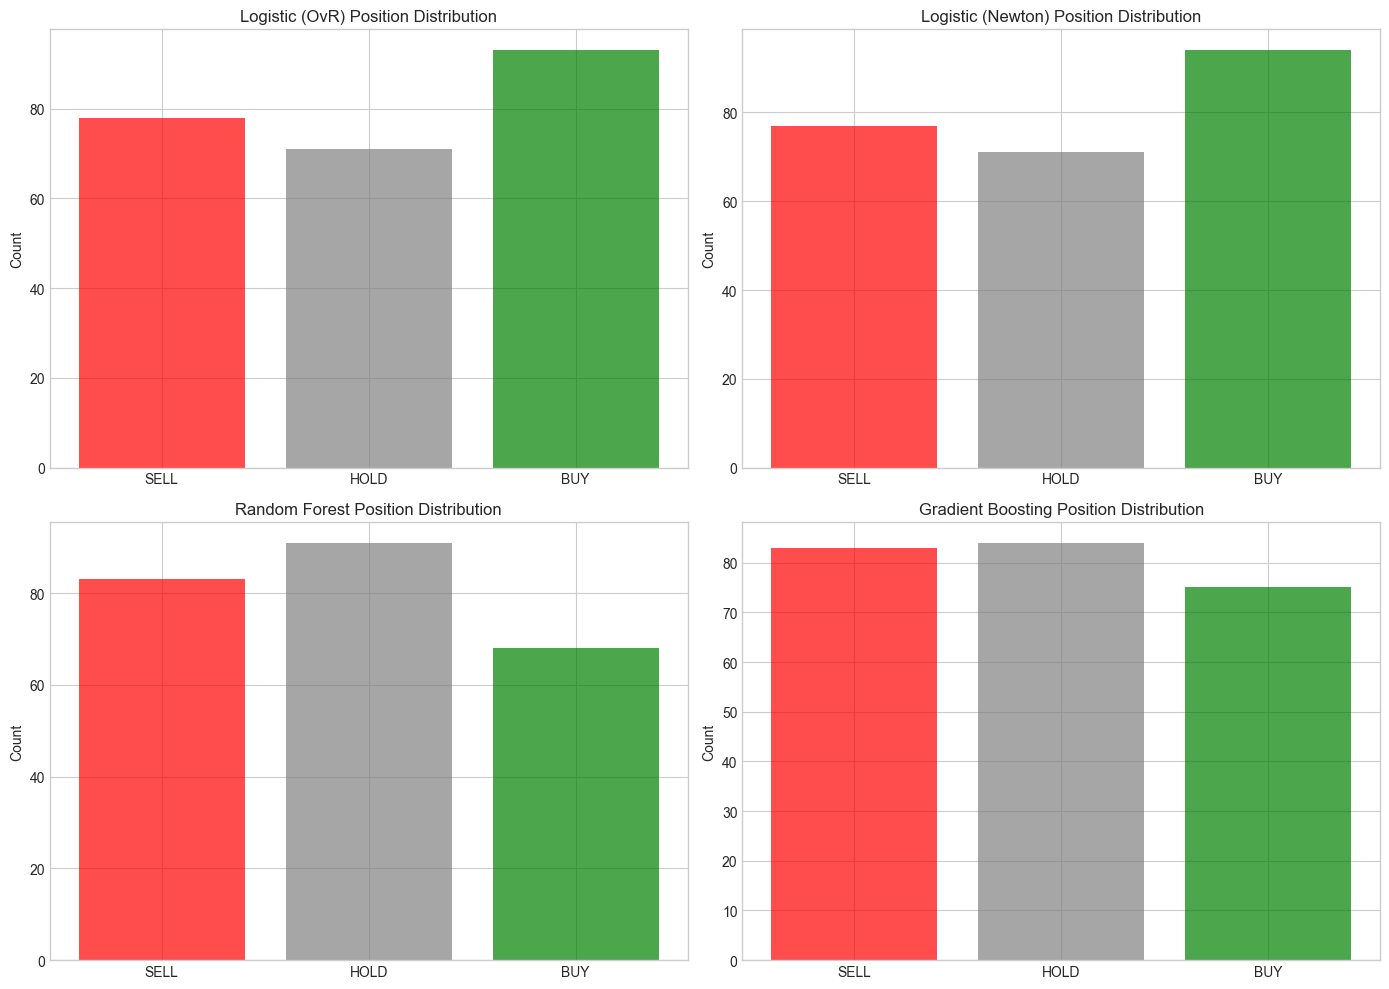

In [11]:
# Position distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, name in enumerate(predictions.keys()):
    pos_counts = backtest[f'{name}_position'].value_counts().sort_index()
    axes[i].bar(pos_counts.index, pos_counts.values, 
                color=['red', 'gray', 'green'], alpha=0.7)
    axes[i].set_xticks([-1, 0, 1])
    axes[i].set_xticklabels(['SELL', 'HOLD', 'BUY'])
    axes[i].set_title(f'{name} Position Distribution')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
# Next day prediction
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 NEXT DAY MULTI-CLASS PREDICTIONS FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

class_labels = ['SELL', 'HOLD', 'BUY']

for name, model in models.items():
    pred = model.predict(latest_scaled)[0]
    proba = model.predict_proba(latest_scaled)[0]
    
    pred_label = class_labels[pred]
    emoji = '📉' if pred == 0 else ('⏸️' if pred == 1 else '📈')
    
    print(f"\n{name}:")
    print(f"  Prediction: {emoji} {pred_label}")
    print(f"  Probabilities: SELL={proba[0]:.1%}, HOLD={proba[1]:.1%}, BUY={proba[2]:.1%}")


📊 NEXT DAY MULTI-CLASS PREDICTIONS FOR AAPL

Date: 2026-01-22

Logistic (OvR):
  Prediction: 📈 BUY
  Probabilities: SELL=30.3%, HOLD=25.0%, BUY=44.6%

Logistic (Newton):
  Prediction: 📈 BUY
  Probabilities: SELL=30.3%, HOLD=25.1%, BUY=44.6%

Random Forest:
  Prediction: 📈 BUY
  Probabilities: SELL=23.7%, HOLD=20.3%, BUY=56.0%

Gradient Boosting:
  Prediction: 📈 BUY
  Probabilities: SELL=21.2%, HOLD=24.3%, BUY=54.5%


---

## 🏢 Real-World Applications

| Company | Multi-Class Use Case |
|---------|---------------------|
| Point72 | Market regime classification |
| Millennium | Signal strength categorization |
| Citadel | Order type prediction |
| Two Sigma | Position sizing buckets |

### Key Interview Points
1. **Why multi-class?** - Accounts for uncertainty, reduces turnover
2. **Threshold selection?** - Balance classes, consider transaction costs
3. **OvR vs Multinomial?** - Multinomial assumes mutual exclusivity
4. **Metrics?** - Use macro/weighted F1, not just accuracy

---
## 📅 Tomorrow: Class Imbalance Handling